# Homework 1: Momentum

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# read data
ret_df = pl.scan_csv("../data/returns_indiv.csv").collect()
ff_factors_df = pl.scan_csv("../data/monthly_ff3.csv").collect()

print(ret_df.head(2))
print(ff_factors_df.head(2))

shape: (2, 58)
┌────────┬──────────┬───────┬──────────┬───┬──────────┬────────────┬──────┬────────┐
│ permno ┆ date     ┆ shrcd ┆ prc      ┆ … ┆ ret_p36  ┆ market_cap ┆ y    ┆ date2  │
│ ---    ┆ ---      ┆ ---   ┆ ---      ┆   ┆ ---      ┆ ---        ┆ ---  ┆ ---    │
│ i64    ┆ i64      ┆ i64   ┆ f64      ┆   ┆ f64      ┆ f64        ┆ i64  ┆ i64    │
╞════════╪══════════╪═══════╪══════════╪═══╪══════════╪════════════╪══════╪════════╡
│ 10032  ┆ 20000630 ┆ 11    ┆ 113.0    ┆ … ┆ -0.0425  ┆ 14.54477   ┆ 2000 ┆ 200006 │
│ 10032  ┆ 20000731 ┆ 11    ┆ 112.8125 ┆ … ┆ 0.255875 ┆ 14.54311   ┆ 2000 ┆ 200007 │
└────────┴──────────┴───────┴──────────┴───┴──────────┴────────────┴──────┴────────┘
shape: (2, 5)
┌────────┬─────────┬─────────┬─────────┬─────────┐
│        ┆ Mkt-RF  ┆ SMB     ┆ HML     ┆ RF      │
│ ---    ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ i64    ┆ str     ┆ str     ┆ str     ┆ str     │
╞════════╪═════════╪═════════╪═════════╪═════════╡
│ 192607 ┆    2.89 ┆   -2.55 ┆   -2.

In [3]:
# change the dtypes for ff_factors_df
ff_factors_df = ff_factors_df.with_columns(
    pl.col("").cast(str).str.to_date("%Y%m").dt.month_end().alias("date"),
    pl.col("Mkt-RF").str.strip_chars().cast(pl.Float64),
    pl.col("SMB").str.strip_chars().cast(pl.Float64),
    pl.col("HML").str.strip_chars().cast(pl.Float64),
    pl.col("RF").str.strip_chars().cast(pl.Float64),
).select("date", "Mkt-RF", "SMB", "HML", "RF")

In [4]:
# change the dates in ret_df into date
ret_df = ret_df.with_columns(
    pl.col("date").cast(str).str.to_date("%Y%m%d").dt.month_end().alias("date"),
)

In [5]:
ret_df.columns

['permno',
 'date',
 'shrcd',
 'prc',
 'ret',
 'shrout',
 'DATE',
 'ret_1',
 'ret_2',
 'ret_3',
 'ret_4',
 'ret_5',
 'ret_6',
 'ret_7',
 'ret_8',
 'ret_9',
 'ret_10',
 'ret_11',
 'ret_12',
 'ret_p1',
 'ret_p2',
 'ret_p3',
 'ret_p4',
 'ret_p5',
 'ret_p6',
 'ret_p7',
 'ret_p8',
 'ret_p9',
 'ret_p10',
 'ret_p11',
 'ret_p12',
 'ret_p13',
 'ret_p14',
 'ret_p15',
 'ret_p16',
 'ret_p17',
 'ret_p18',
 'ret_p19',
 'ret_p20',
 'ret_p21',
 'ret_p22',
 'ret_p23',
 'ret_p24',
 'ret_p25',
 'ret_p26',
 'ret_p27',
 'ret_p28',
 'ret_p29',
 'ret_p30',
 'ret_p31',
 'ret_p32',
 'ret_p33',
 'ret_p34',
 'ret_p35',
 'ret_p36',
 'market_cap',
 'y',
 'date2']

## Question 1
We consider a tradable portfolio strategy that trades in 10 momentum-sorted portfolios based on month-t momentum, hold these portfolios for 1 month, and then rebalance. What is the raw return of these 10 portfolios?

In [ ]:
def construct_momentum_12_1(df: pl.DataFrame) -> pl.DataFrame:
    """
    Construct 12 momentum-sorted portfolios based on month-t momentum, hold these portfolios for 1 month, and then rebalance.
    """
    df = df.with_columns(
        pl.sum_horizontal([pl.col("ret_" + str(i)) for i in range(1, 13)]).alias(
            "mom_12_1"
        ),
    )
    return df.select("permno", "date", "mom_12_1")


def construct_decile_ew_portfolios(
    signal_df: pl.DataFrame, signal_name: str, return_df: pl.DataFrame
) -> pl.DataFrame:
    """
    Construct 10 decile equal-weighted portfolios based on month-t momentum, hold these portfolios for 1 month, and then rebalance.
    Return the portfolio returns.
    """
    # Join signal with forward returns
    df = signal_df.join(
        return_df.select("permno", "date", "ret_p1"),
        on=["permno", "date"],
        how="left",
        validate="1:1",
    )

    # Rank signals within each date and assign to deciles
    df = df.with_columns(
        pl.col(signal_name).rank(method="average").over("date").alias("rank")
    )

    # Calculate decile assignments (1-10)
    df = df.with_columns(
        ((pl.col("rank") - 1) / pl.col("rank").count().over("date") * 10)
        .floor()
        .clip(0, 9)
        .cast(pl.Int64)
        .add(1)
        .alias("decile")
    )

    # Calculate equal-weighted portfolio returns for each decile
    portfolio_returns = (
        df.group_by(["date", "decile"])
        .agg(
            pl.col("ret_p1").mean().alias("portfolio_return"),
            pl.len().alias("n_stocks"),
        )
        .sort(["date", "decile"])
    )

    return portfolio_returns


def construct_decile_vw_portfolios(
    signal_df: pl.DataFrame, signal_name: str, return_df: pl.DataFrame
) -> pl.DataFrame:
    """
    Construct 10 decile value-weighted portfolios based on month-t momentum, hold these portfolios for 1 month, and then rebalance.
    Return the portfolio returns.
    """
    # Join signal with forward returns
    df = signal_df.join(
        return_df.select("permno", "date", "ret_p1", "market_cap"),
        on=["permno", "date"],
        how="left",
        validate="1:1",
    )

    # Rank signals within each date and assign to deciles
    df = df.with_columns(
        pl.col(signal_name).rank(method="average").over("date").alias("rank")
    )

    # Calculate decile assignments (1-10)
    df = df.with_columns(
        ((pl.col("rank") - 1) / pl.col("rank").count().over("date") * 10)
        .floor()
        .clip(0, 9)
        .cast(pl.Int64)
        .add(1)
        .alias("decile")
    )

    # Calculate value-weighted portfolio returns for each decile
    portfolio_returns = (
        df.group_by(["date", "decile"])
        .agg(
            (pl.col("ret_p1") * (pl.col("market_cap") / pl.col("market_cap").sum()))
            .sum()
            .alias("portfolio_return"),
            pl.len().alias("n_stocks"),
        )
        .sort(["date", "decile"])
    )

    return portfolio_returns


def plot_decile_portfolios(
    portfolio_returns_df: pl.DataFrame, signal_name: str
) -> None:
    """
    Plot the decile portfolios cumulative returns.
    Args:
        portfolio_returns_df: pl.DataFrame, the portfolio returns.
        signal_name: str, the name of the signal.
    """
    # Calculate cumulative returns
    portfolio_returns_df = portfolio_returns_df.sort("date").with_columns(
        (1 + pl.col("portfolio_return"))
        .cum_prod()
        .over("decile")
        .alias("cumulative_return")
    )

    # Plot cumulative returns
    portfolio_returns_df_pd = (
        portfolio_returns_df.pivot(
            index="date",
            on="decile",
            values="cumulative_return",
            aggregate_function=None,
        )
        .with_columns(
            (pl.col("10") - pl.col("1")).alias("long_short"),
        )
        .to_pandas()
        .set_index("date")
    )

    portfolio_returns_df_pd.iloc[:, :-1].plot(figsize=(10, 6), linestyle="--")
    portfolio_returns_df_pd.iloc[:, -1].plot(figsize=(10, 6), color="black")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.title(f"Cumulative Returns of Decile Portfolios for {signal_name}")
    plt.show()


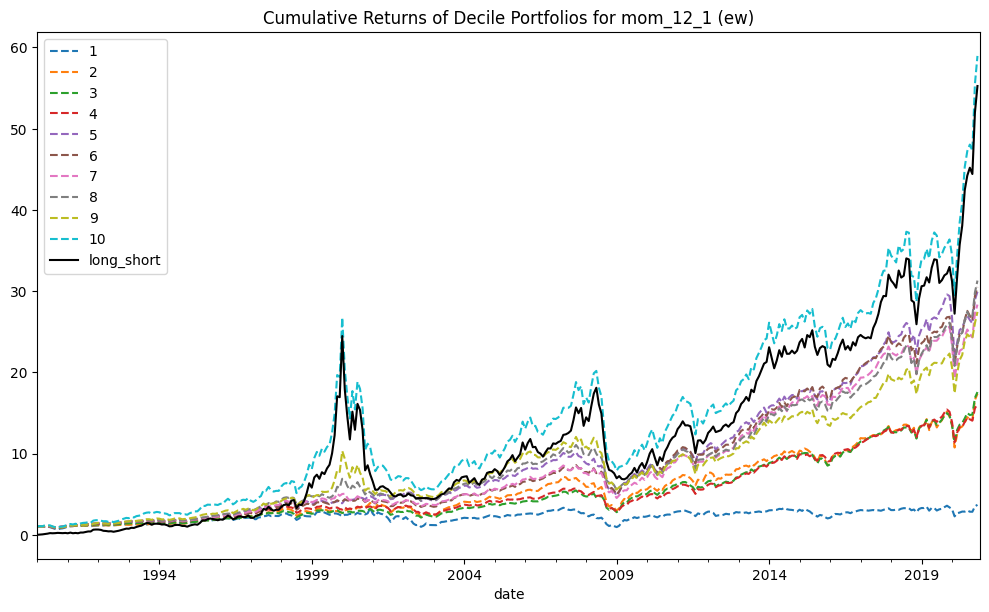

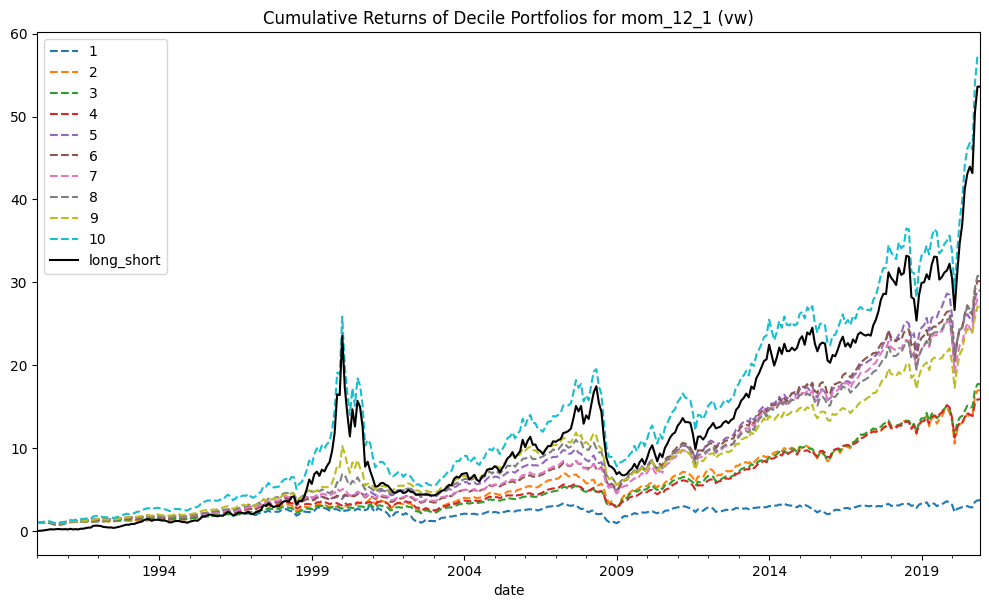

In [ ]:
mom_12_1_df = construct_momentum_12_1(ret_df)
ew_portfolio_returns_df = construct_decile_ew_portfolios(
    mom_12_1_df, "mom_12_1", ret_df
)
vw_portfolio_returns_df = construct_decile_vw_portfolios(
    mom_12_1_df, "mom_12_1", ret_df
)
plot_decile_portfolios(ew_portfolio_returns_df, "mom_12_1 (ew)")
plot_decile_portfolios(vw_portfolio_returns_df, "mom_12_1 (vw)")

## Question 2
Calculate the CAPM $\alpha$ and $\beta$ of these 10 portfolios. Provide standard errors for $\alpha$ and $\beta$.

In [10]:
def run_capm_regression(
    portfolio_returns_df: pl.DataFrame, mkt_factor_df: pl.DataFrame
) -> pd.DataFrame:
    """
    Run the CAPM regression for each portfolio decile.
    Uses groupby.apply to avoid explicit for-loops.
    """
    # Join portfolio returns with market factor (keep long format)
    df = portfolio_returns_df.join(
        mkt_factor_df.select("date", "Mkt-RF", "RF"),
        on="date",
        how="left",
        validate="m:1",
    )

    # Compute excess returns (portfolio return - RF)
    df = df.with_columns(
        (pl.col("portfolio_return") * 100 - pl.col("RF")).alias("excess_return")
    )

    # Convert to pandas for groupby regression
    df_pd = df.select("decile", "excess_return", "Mkt-RF").to_pandas()

    def capm_regression(group: pd.DataFrame) -> pd.Series:
        """Run CAPM regression on a single group."""
        y = group["excess_return"].values
        X = sm.add_constant(group["Mkt-RF"].values)
        model = sm.OLS(y, X, missing="drop").fit()
        return pd.Series(
            {
                "alpha": model.params[0],
                "beta": model.params[1],
                "se_alpha": model.bse[0],
                "se_beta": model.bse[1],
                "t_alpha": model.tvalues[0],
                "t_beta": model.tvalues[1],
            }
        )

    # Run regression per decile using groupby.apply (no explicit for-loop)
    results = df_pd.groupby("decile").apply(capm_regression, include_groups=False)

    return results

In [12]:
# Run CAPM regression for EW and VW portfolios
ew_capm_results = run_capm_regression(ew_portfolio_returns_df, ff_factors_df)
vw_capm_results = run_capm_regression(vw_portfolio_returns_df, ff_factors_df)

print("Equal-Weighted Portfolios CAPM Results:")
display(ew_capm_results.round(4))
print("\nValue-Weighted Portfolios CAPM Results:")
display(vw_capm_results.round(4))

Equal-Weighted Portfolios CAPM Results:


,alpha,beta,se_alpha,se_beta,t_alpha,t_beta
decile,,,,,,
1,0.3377,0.1069,0.3920,0.0883,0.8614,1.2109
2,0.6220,0.1059,0.2791,0.0628,2.2287,1.6855
3,0.6008,0.0933,0.2447,0.0551,2.4554,1.6924
4,0.5649,0.0864,0.2237,0.0504,2.5246,1.7153
5,0.7248,0.0947,0.2204,0.0496,3.2890,1.9081
6,0.7412,0.0693,0.2129,0.0479,3.4818,1.4457
7,0.7400,0.0580,0.2263,0.0510,3.2700,1.1391
8,0.7788,0.0623,0.2444,0.0550,3.1865,1.1318
9,0.7781,0.0761,0.2911,0.0656,2.6726,1.1605



Value-Weighted Portfolios CAPM Results:


,alpha,beta,se_alpha,se_beta,t_alpha,t_beta
decile,,,,,,
1,0.3359,0.1029,0.3888,0.0876,0.8638,1.1757
2,0.6140,0.1031,0.2777,0.0625,2.2112,1.6483
3,0.6018,0.0899,0.2433,0.0548,2.4740,1.6415
4,0.5592,0.0841,0.2222,0.0500,2.5168,1.6814
5,0.7131,0.0934,0.2186,0.0492,3.2614,1.8967
6,0.7355,0.0675,0.2114,0.0476,3.4798,1.4189
7,0.7339,0.0570,0.2243,0.0505,3.2713,1.1294
8,0.7708,0.0603,0.2417,0.0544,3.1893,1.1073
9,0.7705,0.0728,0.2877,0.0648,2.6783,1.1235


## Question 3
Construct a long-short portfolio that goes long the stocks in the top momentum decile and short stocks in the bottom momentum decile and hold these positions for 1 month, and then rebalance. Calculate the strategy’s average raw return, CAPM $\alpha$, Fama-French $\alpha$ and annual Sharpe ratio. What is the t-statistics on the CAPM $\alpha$ and the FF $\alpha$?

In [ ]:
def construct_long_short_portfolio(portfolio_returns_df: pl.DataFrame) -> pl.DataFrame:
    """
    Construct a long-short portfolio: long top decile (10), short bottom decile (1).
    """
    # Pivot to get decile returns side by side
    pivoted = portfolio_returns_df.pivot(
        index="date",
        on="decile",
        values="portfolio_return",
        aggregate_function=None,
    )

    # Long-short return = decile 10 - decile 1
    ls_df = pivoted.select(
        pl.col("date"),
        (pl.col("10") - pl.col("1")).alias("ls_return"),
    )

    return ls_df


def calculate_ls_statistics(ls_df: pl.DataFrame, ff_factors_df: pl.DataFrame) -> dict:
    """
    Calculate long-short portfolio statistics:
    - Average raw return
    - CAPM alpha and t-stat
    - Fama-French 3-factor alpha and t-stat
    - Annual Sharpe ratio
    """
    # Join with FF factors
    df = ls_df.join(
        ff_factors_df.select("date", "Mkt-RF", "SMB", "HML", "RF"),
        on="date",
        how="inner",
    )

    # Compute excess return (convert to percent to match FF factors)
    df = df.with_columns(
        (pl.col("ls_return") * 100 - pl.col("RF")).alias("excess_return"),
        (pl.col("ls_return") * 100).alias("raw_return"),
    )

    df_pd = df.to_pandas()

    # Average raw return (monthly, in percent)
    avg_raw_return = df_pd["raw_return"].mean()

    # CAPM regression: excess_return = alpha + beta * Mkt-RF + epsilon
    y_capm = df_pd["excess_return"].values
    X_capm = sm.add_constant(df_pd["Mkt-RF"].values)
    capm_model = sm.OLS(y_capm, X_capm, missing="drop").fit()
    capm_alpha = capm_model.params[0]
    capm_alpha_tstat = capm_model.tvalues[0]

    # Fama-French 3-factor regression
    y_ff = df_pd["excess_return"].values
    X_ff = sm.add_constant(df_pd[["Mkt-RF", "SMB", "HML"]].values)
    ff_model = sm.OLS(y_ff, X_ff, missing="drop").fit()
    ff_alpha = ff_model.params[0]
    ff_alpha_tstat = ff_model.tvalues[0]

    # Annual Sharpe ratio: (mean excess return / std excess return) * sqrt(12)
    mean_excess = df_pd["excess_return"].mean()
    std_excess = df_pd["excess_return"].std()
    annual_sharpe = (mean_excess / std_excess) * np.sqrt(12)

    return {
        "avg_raw_return_monthly_pct": avg_raw_return,
        "capm_alpha": capm_alpha,
        "capm_alpha_tstat": capm_alpha_tstat,
        "ff_alpha": ff_alpha,
        "ff_alpha_tstat": ff_alpha_tstat,
        "annual_sharpe": annual_sharpe,
    }

In [ ]:
# Construct long-short portfolios for EW and VW
ew_ls_df = construct_long_short_portfolio(ew_portfolio_returns_df)
vw_ls_df = construct_long_short_portfolio(vw_portfolio_returns_df)

# Calculate statistics
ew_ls_stats = calculate_ls_statistics(ew_ls_df, ff_factors_df)
vw_ls_stats = calculate_ls_statistics(vw_ls_df, ff_factors_df)

# Display results
results_df = pd.DataFrame(
    {
        "Equal-Weighted": ew_ls_stats,
        "Value-Weighted": vw_ls_stats,
    }
).T

print("Long-Short Portfolio (Decile 10 - Decile 1) Statistics:")
display(results_df.round(4))

## Question 4